In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset,random_split
import random
import os

In [2]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
data1 = np.load('./data/data0.npy')
lab1 = np.load('./data/lab0.npy')
data2 = np.load('./data/data1.npy')
lab2 = np.load('./data/lab1.npy')
data3 = np.load('./data/data2.npy')
lab3 = np.load('./data/lab2.npy')

In [5]:
data_cumulative = np.concat([data1,data2,data3])
data_cumulative = data_cumulative[:, np.newaxis, :, :]
labels_cumulative = np.concat([lab1,lab2,lab3])
data = torch.tensor(data_cumulative, dtype=torch.float32).to(device)
labels = torch.tensor(labels_cumulative, dtype=torch.long).to(device)

In [6]:
dataset = TensorDataset(data, labels)

In [7]:
train_size = int(0.85 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [8]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=37):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(128 * 5 * 21, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.7)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


In [10]:
model = CNNModel().to(device)

In [11]:
learn_rate = 1e-3
loss_func = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(),lr= learn_rate)
num_epochs = 8

In [12]:
from tqdm import tqdm

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
progress_bar = tqdm(range(num_epochs), desc="Training Loop")

for epoch in progress_bar:
    loss_epoch = 0
    total_train = 0
    correct_train = 0
    
    # Training phase
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        optimiser.zero_grad()
        loss = loss_func(output, labels)
        loss.backward()
        optimiser.step()
        loss_epoch += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_train += len(labels)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = loss_epoch / len(train_loader)
    train_accuracy = 100 * (correct_train / total_train)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    
    # Validation phase
    with torch.no_grad():
        loss_val = 0
        total_val = 0
        correct_val = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss_val += loss_func(output, labels).item()
            _, predicted = torch.max(output.data, 1)
            total_val += len(labels)
            correct_val += (predicted == labels).sum().item()
        
        val_loss = loss_val / len(val_loader)
        val_accuracy = 100 * (correct_val / total_val)
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)
    
    progress_bar.set_postfix(
        train_loss=f"{train_loss:.4f}",
        train_acc=f"{train_accuracy:.2f}%",
        val_loss=f"{val_loss:.4f}",
        val_acc=f"{val_accuracy:.2f}%"
    )


Training Loop: 100%|██████████| 8/8 [00:59<00:00,  7.39s/it, train_acc=14.62%, train_loss=2.5105, val_acc=13.23%, val_loss=2.6123]


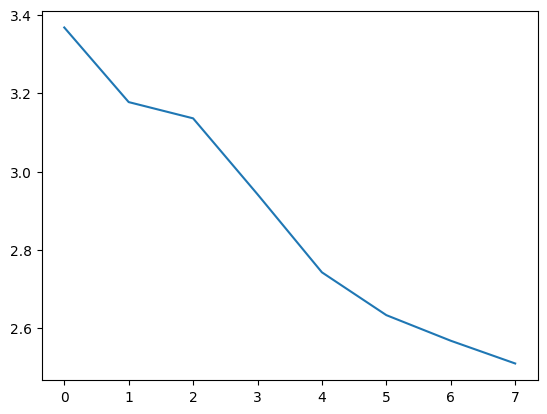

In [13]:
plt.plot(train_losses)

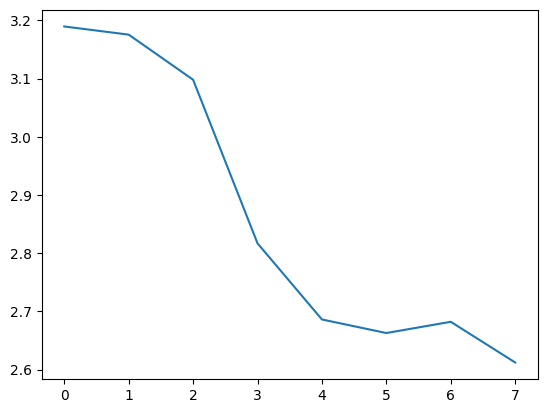

In [14]:
plt.plot(val_losses)

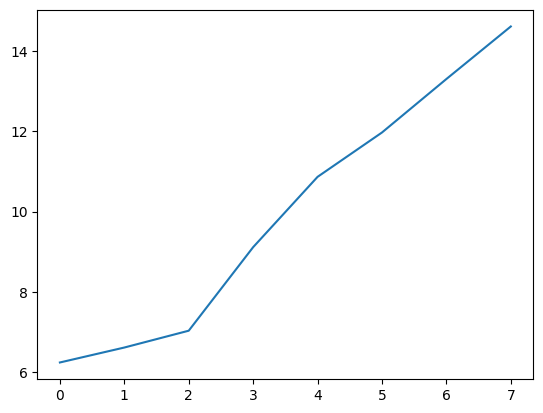

In [15]:
plt.plot(train_accuracies)

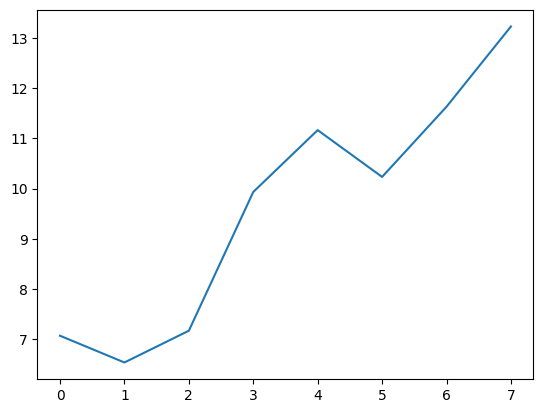

In [16]:
plt.plot(val_accuracies)

In [17]:
torch.save(model,"model.pth")